In [1]:
!pip install cmake
!pip install dlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import dlib
print(dlib.__version__)


19.24.6


In [3]:
pip install face_recognition

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [4]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import face_recognition
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

## Highlight Facial Points in the Image

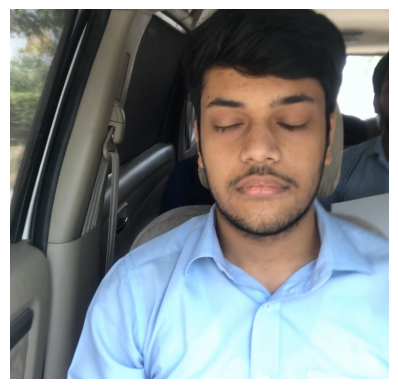

In [5]:
image_path = 'test1.png'
image = Image.open(image_path)
plt.axis('off')
plt.imshow(image)
plt.show()

In [6]:
def highlight_facial_points(image_path):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(image_rgb, model = 'cnn')

    for face_location in face_locations:

        landmarks = face_recognition.face_landmarks(image_rgb, [face_location])[0]

        for landmark_type, landmark_points in landmarks.items():
            for(x,y) in landmark_points:
                cv2.circle(image_rgb, (x,y), 3, (0, 255, 0), -1)
    
    plt.figure(figsize=(6,6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [ ]:
highlight_facial_points(image_path)

<img src = 'facial_landmarks.png'>

In [ ]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A + B) / (2.0 * C)
    return mar

In [ ]:
def process_image(frame):
    EYE_AR_THRESH = 0.25
    MOUTH_AR_THRESH = 0.6

    if frame is None:
        raise ValueError('Image not found')

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    face_locations = face_recognition.face_locations(rgb_frame)

    eye_flag = mouth_flag = False

    for face_location in face_locations:
        landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]

        left_eye = np.array(landmarks['left_eye'])
        right_eye = np.array(landmarks['right_eye'])
        mouth = np.array(landmarks['bottom_lip'])

        left_ear = eye_aspect_ratio(left_eye)
        right_ear = eye_aspect_ratio(right_eye)
        ear = (left_ear + right_ear) / 2.0
        mar = mouth_aspect_ratio(mouth)

        if ear < EYE_AR_THRESH:
            eye_flag = True

        if mar > MOUTH_AR_THRESH:
            mouth_flag = True

    return eye_flag, mouth_flag

In [ ]:
img = cv2.imread(image_path)
process_image(img)

## Real Time Drowsiness Detection

In [ ]:
# for live webcam:
#video_cap = cv2.VideoCapture(0)
#for sample video:
video_path = "test.mp4"
video_cap = cv2.VideoCapture(video_path)
count = score = 0

while True:
    success, image = video_cap.read()
    if not success:
        break

    image = cv2.resize(image, (800, 500))

    count += 1
    # process every 5th frame 
    n = 5
    if count % n == 0:
        eye_flag, mouth_flag = process_image(image)
        if eye_flag or mouth_flag:
            score += 1
        else:
            score-= 1
            if score < 0:
                score = 0

    font = cv2.FONT_HERSHEY_COMPLEX
    text_x = 10
    text_y = image.shape[0] - 10
    text = f"Score: {score}"
    cv2.putText(image, text, (text_x, text_y), font, 1, (20,255,0), 2, cv2.LINE_AA)

    if score >= 5:
        text_x = image.shape[1]- 130
        text_y = 40
        text = "Drowsy"
        cv2.putText(image, text, (text_x, text_y), font, 1, (10,10,255), 2, cv2.LINE_AA)

    cv2.imshow('drowsiness detection', image)

    if cv2.waitKey(1) & 0xff != 255:
        break

video_cap.release()
cv2.destroyAllWindows()